## Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Import Data

In [2]:
# Load the data, contained in the segmentation data csv file.
df_segmentation = pd.read_csv('segmentation data.csv', index_col = 0)

## Standardization

In [3]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### PCA

In [4]:
# Employ PCA to find a subset of components, which explain the variance in the data.
pca = PCA().fit(segmentation_std)

In [5]:
# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0,0.5,'Cumulative Explained Variance')

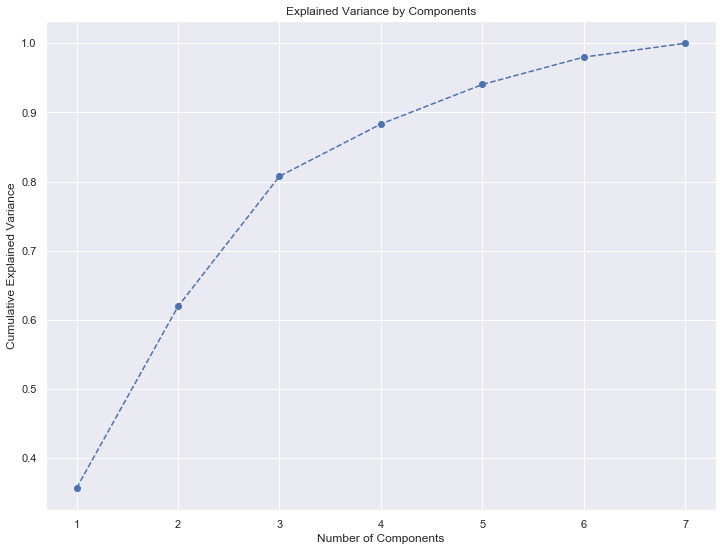

In [6]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [7]:
# choose three components. 3 or 4 seems the right choice according to the previous graph.
pca = PCA(n_components = 3).fit(segmentation_std)

### PCA results

In [8]:
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features. 
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [9]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


([<matplotlib.axis.YTick at 0x11ff59350>,
 <a list of 3 Text yticklabel objects>)

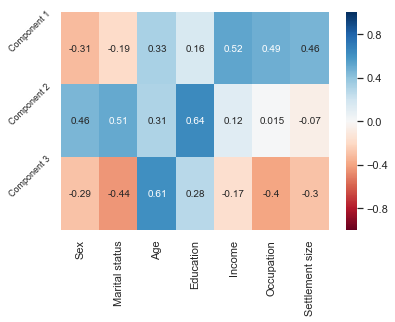

In [10]:
# heatmap for Principal Components against original features.
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)

In [11]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [12]:
scores_pca = pca.transform(segmentation_std)

### K-means clustering with PCA

In [13]:
# fitting K means using the transformed data from the PCA.
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

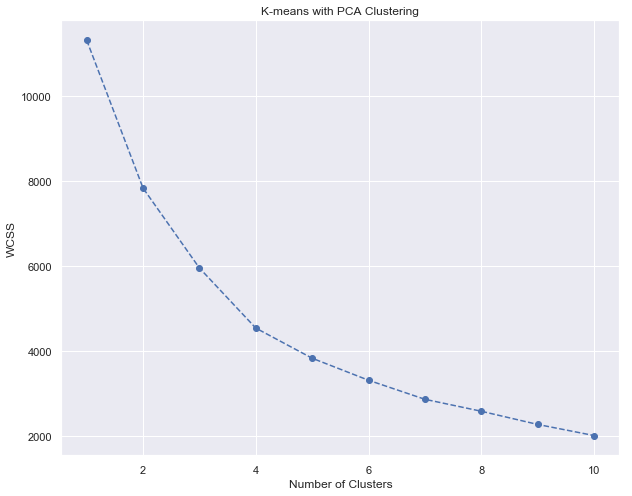

In [14]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [15]:
# Since 4 clusters were choosen, we run K-means with number of clusters equals 4. 
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42).fit(scores_pca)

### K-means clustering with PCA Results

In [16]:
# creating a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

# This last column to add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [17]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
5,0,0,35,1,144848,0,0,-0.274734,-0.871070,1.310152,2
6,0,0,53,1,156495,1,1,1.729504,-0.416069,1.212454,1
7,0,0,35,1,193621,2,1,2.510377,-0.751256,-0.504917,1
8,0,1,61,2,151591,0,0,0.419891,1.936115,2.209117,3
9,0,1,28,1,174646,2,0,1.098729,0.111131,-1.306561,1


In [18]:
# calculating the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


In [19]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
standard,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
fewer opportunities,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
well-off,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


In [20]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})

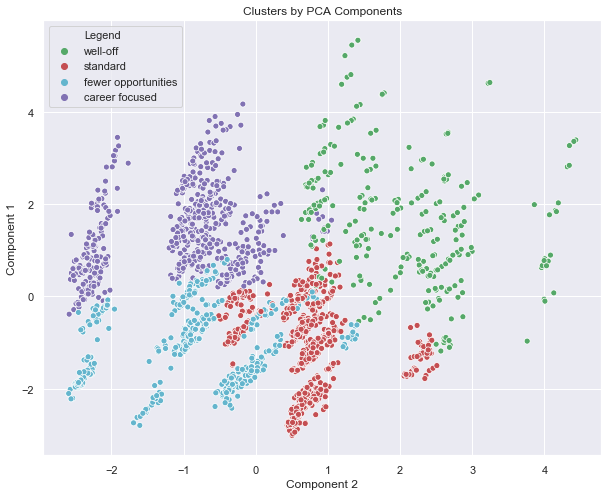

In [21]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()